In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchvision import transforms
from PIL import Image
import os

Training samples: 8000
Validation samples: 2000
torch.Size([1, 150, 150])


/home/vimarsh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


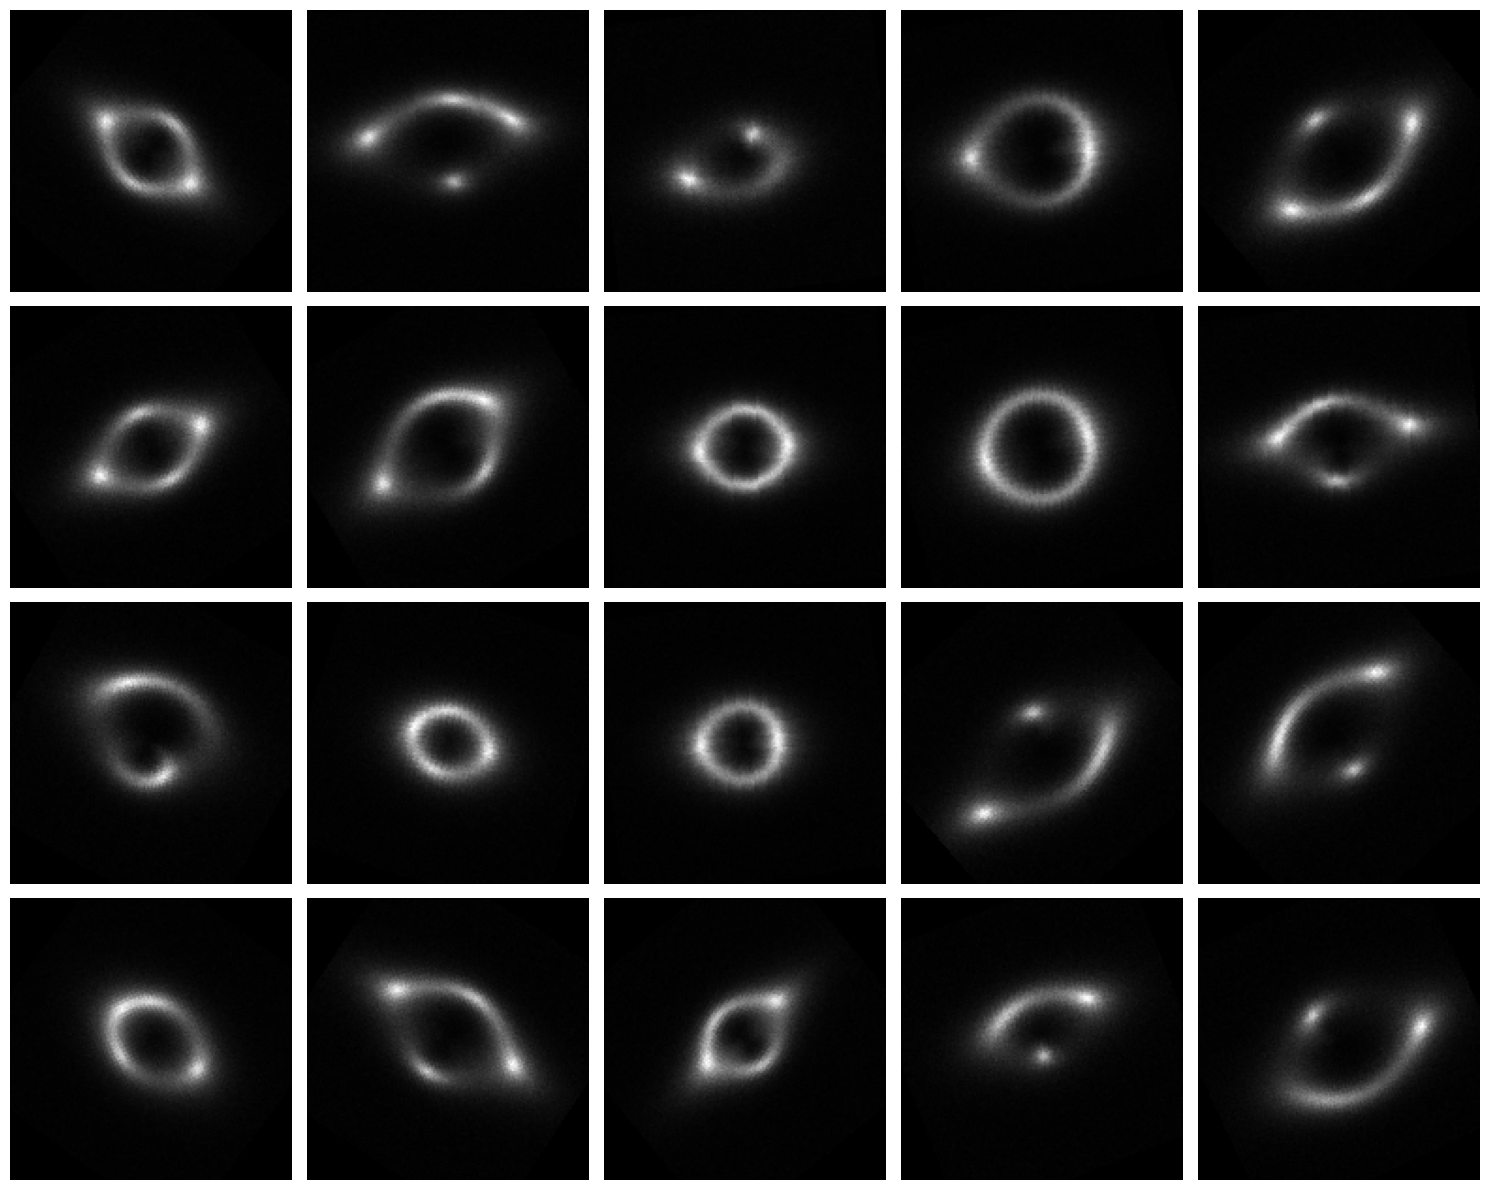

In [2]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import glob
class NpyImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with all the .npy image files
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.data_dir = data_dir
        self.transform = transform
        
        # Get all .npy files
        self.image_paths = glob.glob(os.path.join(data_dir, '*.npy'))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = np.load(self.image_paths[idx])
        
        # Convert to torch tensor
        image = torch.from_numpy(image).float()
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor()
])

# Create dataset
dataset = NpyImageDataset(data_dir='/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/Diffusion_Samples/Samples', transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
dataset_train, dataset_val = random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_val)}")

print(dataset_train[0].shape)

# Create data loaders
batch_size = 32
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

#randomly plotting some images
import matplotlib.pyplot as plt
import numpy
import random
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()
for i in range(20):
    idx = random.randint(0, len(dataset) - 1)
    img = dataset[idx]
    img = img.permute(1, 2, 0)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# Hyperparameters
T = 1000  # Number of timesteps
beta_schedule = get_noise_schedule(T)
alphas = 1 - beta_schedule
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)

# Training loop skeleton
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
mse_loss = nn.MSELoss()


num_epochs = 10
for epoch in range(num_epochs):
    for x_0 in train_loader:
        x_0 = x_0.to(device)
        # Sample random timestep for each image in batch
        t = torch.randint(0, T, (x_0.size(0),), device=device)
        t_emb = get_timestep_embedding(t, embedding_dim=128).to(device)
        
        # Get corresponding alpha values for timestep t
        a_t = alphas_cumprod[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x_0)
        x_t = torch.sqrt(a_t) * x_0 + torch.sqrt(1 - a_t) * noise
        
        # Predict the noise using the network conditioned on t_emb
        noise_pred = model(x_t, t_emb)
        loss = mse_loss(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/10, Loss: 0.04846092313528061
Epoch 2/10, Loss: 0.013903544284403324
Epoch 3/10, Loss: 0.004850982688367367
Epoch 4/10, Loss: 0.005793359596282244
Epoch 5/10, Loss: 0.005174726247787476
Epoch 6/10, Loss: 0.0042317877523601055
Epoch 7/10, Loss: 0.015572811476886272
Epoch 8/10, Loss: 0.009918495081365108
Epoch 9/10, Loss: 0.0045558433048427105
Epoch 10/10, Loss: 0.00471200468018651


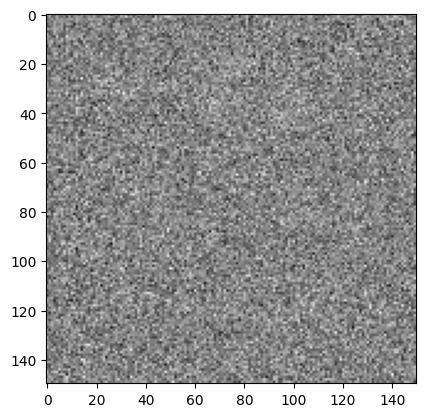

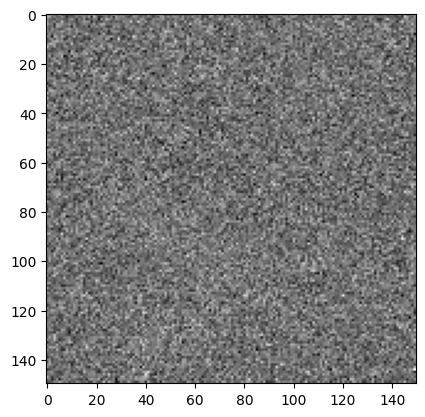

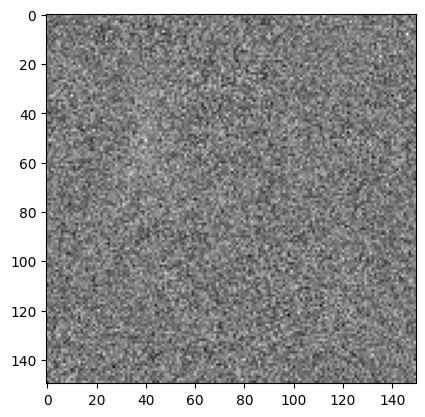

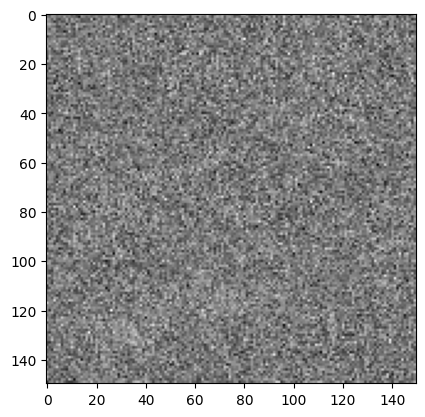

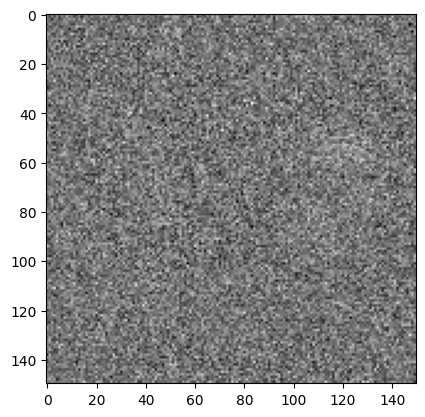

In [6]:
@torch.no_grad()
def sample(model, shape, T, alphas, alphas_cumprod, device):
    x = torch.randn(shape, device=device)
    for t in reversed(range(T)):
        t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
        t_emb = get_timestep_embedding(t_tensor, embedding_dim=128).to(device)
        noise_pred = model(x, t_emb)
        
        a_t = alphas[t]
        a_cumprod = alphas_cumprod[t]
        # Simplified reverse update (for illustration)
        x = (x - (1 - a_t) / torch.sqrt(1 - a_cumprod) * noise_pred) / torch.sqrt(a_t)
        if t > 0:
            x += torch.randn_like(x) * 0.1  # add noise for stochasticity
    return x

# Generate the same number of samples as in the validation set.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_samples = len(val_loader.dataset)
num_samples = 5
generated_images = sample(model, (num_samples, 1, 150, 150), T, alphas, alphas_cumprod, device)

# Plot some generated images
generated_images = generated_images.cpu()
for i in range(num_samples):
    img = generated_images[i].squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

In [7]:
import numpy as np
import torch.nn.functional as F
from torchvision.models import inception_v3
from scipy.linalg import sqrtm

# Prepare Inception model for feature extraction
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.fc = torch.nn.Identity()  # Remove final classification layer
inception_model.to(device)
inception_model.eval()

# Function to extract features
def get_inception_features(dataloader, model, device):
    features = []
    with torch.no_grad():
        for batch in dataloader:
            # Resize images to 299x299 as required by Inception
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            batch = batch.to(device)
            pred = model(batch)  # Shape: (batch_size, 2048)
            features.append(pred.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features

# Create dataloaders for real (validation) and generated images
# For generated images, we wrap them in a TensorDataset
from torch.utils.data import TensorDataset

gen_dataset = TensorDataset(generated_images.cpu())
gen_loader = DataLoader(gen_dataset, batch_size=16, shuffle=False)

# For real images, we can use the validation loader
real_features = get_inception_features(val_loader, inception_model, device)
gen_features = get_inception_features(gen_loader, inception_model, device)

# Calculate the mean and covariance of the features
mu_real = np.mean(real_features, axis=0)
sigma_real = np.cov(real_features, rowvar=False)
mu_gen = np.mean(gen_features, axis=0)
sigma_gen = np.cov(gen_features, rowvar=False)

# Function to calculate FID
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

fid_score = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print(f"FID Score on Validation Data: {fid_score:.2f}")

/home/vimarsh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vimarsh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 299, 299] to have 3 channels, but got 1 channels instead